In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

import matplotlib.pyplot as plt
plt.ion()

In [2]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [3]:
root_dir = "Dataset/"
epochs = 10
batch_size = 1
maxFaces = 27

In [4]:
neg_train = sorted(os.listdir('Dataset/emotiw/train/'+'Negative/'))
neu_train = sorted(os.listdir('Dataset/emotiw/train/'+'Neutral/'))
pos_train = sorted(os.listdir('Dataset/emotiw/train/'+'Positive/'))

neg_val = sorted(os.listdir('Dataset/emotiw/val/' + 'Negative/'))
neu_val = sorted(os.listdir('Dataset/emotiw/val/' + 'Neutral/'))
pos_val = sorted(os.listdir('Dataset/emotiw/val/' + 'Positive/'))

In [5]:
neg_train = neg_train[1:]
pos_val = pos_val[1:]
neu_val = neu_val[1:]
neg_val = neg_val[1:]

In [6]:
train_filelist = neg_train + neu_train + pos_train
val_filelist = neg_val + neu_val + pos_val
print(len(train_filelist),len(val_filelist))

9808 4342


In [7]:
train_data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [8]:
class EmotiWDataset(Dataset):
    
    def __init__(self, filelist, root_dir, loadTrain=True, transform=transforms.ToTensor()):
        """
        Args:
            filelist: List of names of image/feature files.
            root_dir: Dataset directory
            transform (callable, optional): Optional transformer to be applied
                                            on an image sample.
        """
        
        self.filelist = filelist
        self.root_dir = root_dir
        self.transform = transform
        self.loadTrain = loadTrain
            
    def __len__(self):
        return (len(train_filelist))   
    
    def __getitem__(self, idx):
        train = ''
        if self.loadTrain:
            train = 'train'
        else:
            train = 'val'
        filename = self.filelist[idx].split('.')[0]
        labeldict = {'neg':'Negative',
                     'neu':'Neutral',
                     'pos':'Positive',
                     'Negative': 0,
                     'Neutral': 1,
                     'Positive':2}

        labelname = labeldict[filename.split('_')[0]]
        image = Image.open(self.root_dir+'emotiw/'+train+'/'+labelname+'/'+filename+'.jpg')
        if self.transform:
            image = self.transform(image)
        if image.shape[0] == 1:
            image_1 = np.zeros((3, 224, 224), dtype = float)
            image_1[0] = image
            image_1[1] = image
            image_1[2] = image
            image = image_1
            image = torch.FloatTensor(image.tolist())
        features = np.load(self.root_dir+'FaceFeatures/'+train+'/'+labelname+'/'+filename+'.npz')['a']
        numberFaces = features.shape[0]
        maxNumber = min(numberFaces, maxFaces)
        features1 = np.zeros((maxFaces, 256), dtype = 'float32')
        for i in range(maxNumber):
            features1[i] = features[i]
        features1 = torch.from_numpy(features1)
        sample = {'image': image, 'features': features1, 'label':labeldict[labelname], 'numberFaces': numberFaces}
        return sample

In [9]:
train_dataset = EmotiWDataset(train_filelist, root_dir, loadTrain = True, transform=train_data_transform)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)

In [10]:
val_dataset = EmotiWDataset(val_filelist, root_dir, loadTrain=False, transform = val_data_transform)

val_dataloader = DataLoader(val_dataset, shuffle =True, batch_size = batch_size, num_workers = 0)

0 torch.Size([1, 3, 224, 224]) torch.Size([1, 27, 256]) torch.Size([1]) torch.Size([1])


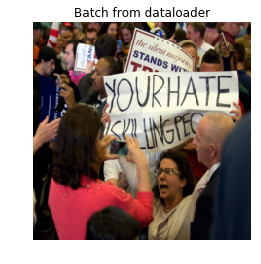

In [11]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch, label, numberFaces = \
            sample_batched['image'], sample_batched['features'], sample_batched['label'], sample_batched['numberFaces']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
#         plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
#                     landmarks_batch[i, :, 1].numpy(),
#                     s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['features'].size(),
          sample_batched['label'].size(), sample_batched['numberFaces'].size())

    # observe 4th batch and stop.
    if i_batch == 0:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [19]:
# global_model = nn.Sequential(*list(models.densenet161(pretrained = True).children())[:-1])

global_model = models.densenet161(pretrained=True)
num_ftrs = global_model.classifier.in_features
global_model.classifier = nn.Linear(num_ftrs, 1024)

C:\Users\neela\Anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [32]:
class FaceAttention(nn.Module):
    def __init__(self, global_model):
        super(FaceAttention, self).__init__()
        
        self.global_model = global_model
        
#         self.global_fc1 = nn.Linear(2208, 1024)
        self.global_fc2 = nn.Linear(1024, 256)
        
        self.classifier_fc1 = nn.Linear(512, 128)
        self.classifier_fc2 = nn.Linear(128, 32)
        self.classifier_fc3 = nn.Linear(32, 3)
    
    def forward(self, image, face_features, numberFaces):
        global_features_initial = self.global_model.forward(image)
        global_features_initial = global_features_initial.view(-1, 1, 1024)
        global_features = F.relu(self.global_fc2(global_features_initial))
        batch_size = global_features.shape[0]
        face_features = face_features.view(batch_size, 256, -1)
        maxNumber = min(numberFaces, maxFaces)
        mask = np.zeros((1,maxFaces), dtype = 'float32')
        for i in range(maxFaces-maxNumber):
            mask[0][numberFaces + i] = float('-inf')
        mask = torch.from_numpy(mask)
        attention_scores = torch.bmm(global_features, face_features) #(batch_size, 1, 256) x (batch_size, 256, nFaces) = (batch_size, 1, nFaces)
        attention_scores = attention_scores+mask
        
        #Convert Scores to Weight
        attention_scores = F.softmax(attention_scores, dim = -1)
        
        attention_weights = attention_scores
        
        #Taking Weighted Average of Face Featrues
        face_features = face_features.view(batch_size, -1, 256) #(batch_size, nFaces, 256)
        attention_weights = attention_weights.view(batch_size, 1, -1) #(batch_size, 1, nFaces)
        attended_face_features = torch.bmm(attention_weights, face_features)
        
        #Concatenating Global and Attended Face Features 
        attended_face_features = attended_face_features.view(batch_size, -1)
        global_features = global_features.view(batch_size, -1)
        final_features = torch.cat((attended_face_features, global_features), dim=1)
        
        x = F.relu(self.classifier_fc1(final_features.view(-1, 512)))
        x = F.relu(self.classifier_fc2(x))
        x = F.relu(self.classifier_fc3(x))
        
        return x

In [33]:
model_ft = FaceAttention(global_model)
model_ft = model_ft.to(device)

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in range(2):            
            if phase == 0:
                dataloaders = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloaders = val_dataloader
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for i_batch, sample_batched in enumerate(dataloaders):
                inputs = sample_batched['image']
                labels = sample_batched['label']
                face_features = sample_batched['features']
                numberFaces = sample_batched['numberFaces']
                inputs = inputs.to(device)
                labels = labels.to(device)
                face_features = face_features.to(device)
                numberFaces = numberFaces.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 0):
#                     print("forward")
                    outputs = model(inputs, face_features, numberFaces)
#                     print("forward done")
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
#                     print("loss done")
                    
                    if phase == 0:
                        loss.backward()
                        optimizer.step()
#                         print("backward done")
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elapsed = time.time() - since
    print('Training complete in {: .0f}m {:0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [35]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

In [36]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
model = train_model(model_ft, criterion, optimizer_ft, 
                      exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
forward
forward done
loss done
backward done
forward
forward done
loss done
backward done
forward


KeyboardInterrupt: 

# Testing

In [37]:
# from torch.autograd import Variable

# numberFaces = 13
# maxFaces = 10
# maxNumber = min(numberFaces, maxFaces)

# mask = np.zeros((1,10), dtype = 'float32')
# for i in range(maxFaces-maxNumber):
#     mask[0][numberFaces + i] = float('-inf')
# mask = torch.from_numpy(mask)

# attention_scores = np.zeros((32, 1, 10), dtype = 'float32')
# attention_scores = torch.from_numpy(attention_scores)
# print(attention_scores)
# attention_scores = attention_scores+mask
# print(attention_scores)
# attention_scores = Variable(attention_scores)

# # attention_scores.view(batch_size, -1)
# # exp_sum = attention_scores.exp_().sum(dim = 1)
# # print(exp_sum)
# # for i in range(batch_size):
# #     attention_scores[i] = attention_scores[i]/exp_sum[i] 
# attention_scores = F.softmax(attention_scores, dim = -1)
# print(attention_scores)
# attention_weights = attention_scores


(0 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(1 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(2 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(3 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(4 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(5 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(6 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(7 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(8 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(9 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(10,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(11,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(12,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(13,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(14,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(15,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(16,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(17,.,.) = 
   0   0   0   0   0   0   0   0   0   0

(18,.,.) = 
   0   0   0   